<a href="https://colab.research.google.com/github/comHack/Mammography_DL_Classification/blob/master/FirstAttempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

Don't forget to change runtime type to GPU/TPU:
    - Go to Runtime -> Change runtime type 

In [0]:
import numpy as np

#import pandas as pd

#import cv2

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

import random

import shutil

import os

from google.colab import drive

# **Mounting Drive**

In [3]:
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


FileExistsError: ignored

# **Splitting the data**

## Directories paths

In [0]:
#data folder link to the images_resized_2 folder in your drive
data_folder = '/gdrive/My Drive/Breast_Cancer_Detection/images_resized_2'


In [0]:
workspace_models = data_folder + '/Saved_Models'

In [0]:
#Workspace is the folder that will contain a copy of the images
#The workspace folder is arranged so ImageDataGenerator can be used
workspace = data_folder + '/workspace'

workspace_train = workspace + '/train'
workspace_val = workspace + '/val'
workspace_test = workspace + '/test'

workspace_models = data_folder + '/Saved_Models'

train_benign = workspace_train + '/benign'
train_malign = workspace_train + '/malign'

val_benign = workspace_val + '/benign'
val_malign = workspace_val + '/malign'

test_benign = workspace_test + '/benign'
test_malign = workspace_test + '/malign'




## Creating directories

In [0]:
try:
    os.mkdir(workspace)
    os.mkdir(workspace_train)
    os.mkdir(workspace_val)
    os.mkdir(workspace_test)
    os.mkdir(workspace_models)
    os.mkdir(train_benign)
    os.mkdir(train_malign)
    os.mkdir(val_benign)
    os.mkdir(val_malign)
    os.mkdir(test_benign)
    os.mkdir(test_malign)
except OSError:
    pass

## Splitting data to respective directories

In [0]:
def split(src, train, val, test, size=0.7):
    '''

    randomly split the data to train, validation and test set 

    the train set will take size*100% of the data

    the rest split equally between the validation and test set

    '''
    global workspace_train, workspace_val, workspace_test

    folders = ['/benign', '/malign']

    for folder in folders:

        data = os.listdir(src + folder)

        random_set = random.sample(data, len(data))

        train_size = int(len(data) * size)

        val_size = int(len(data) * ((1 - size) / 2))

        print('train_size = ' + str(train_size))
        print('val_size = ' + str(val_size))

        train_set = random_set[0: train_size]

        val_set = random_set[train_size + 1: train_size + val_size]

        test_set = random_set[train_size + val_size + 1:]

        for file in train_set:
            source = src + folder + '/' + file
            destination = workspace_train + folder + '/' + file
            try:
                shutil.copyfile(source, destination)
                print("------ Copied " + source + " to " + destination)
            except OSError:
                print("------ |||| FAILED COPYING " + file + " |||| --")

        for file in val_set:
            source = src + folder + '/' + file
            destination = workspace_val + folder + '/' + file
            try:
                shutil.copyfile(source, destination)
                print("------ Copied " + source + " to " + destination)
            except OSError:
                print("------ |||| FAILED COPYING " + file + " |||| --")

        for file in test_set:
            source = src + folder + '/' + file
            destination = workspace_test + folder + '/' + file
            try:
                shutil.copyfile(source, destination)
                print("------ Copied " + source + " to " + destination)
            except OSError:
                print("------ |||| FAILED COPYING " + file + " |||| --")


In [0]:
#10 - 15 minutes
split(data_folder, workspace_train, workspace_val, workspace_test, size=0.8)

## Checking the split

**All the data**

In [5]:
len(os.listdir(data_folder + '/benign'))

2001

In [5]:
len(os.listdir(data_folder + '/malign'))

2010

**Training data**

In [6]:
len(os.listdir(train_benign))

1599

In [7]:
len(os.listdir(train_malign))

1608

In [0]:
len(os.listdir(train_benign)) + len(os.listdir(train_malign))

3207

**Validation data**

In [0]:
len(os.listdir(val_benign))

200

In [0]:
len(os.listdir(val_malign))

200

In [9]:
len(os.listdir(val_benign)) + len(os.listdir(val_malign))

400

**Testing data**

In [0]:
len(os.listdir(test_benign))

201

In [0]:
len(os.listdir(test_malign))

202

In [8]:
len(os.listdir(test_benign)) + len(os.listdir(test_malign))

403

Copy the dataset to the colab instance.

In [18]:
workspace

'/gdrive/My Drive/Breast_Cancer_Detection/images_resized_2/workspace'

In [0]:
!cp -r '/gdrive/My Drive/Breast_Cancer_Detection/images_resized_2/workspace' 'workspace'

In [0]:
workspace = '/content' + '/workspace'

workspace_train = workspace + '/train'
workspace_val = workspace + '/val'
workspace_test = workspace + '/test'

#workspace_models = data_folder + '/Saved_Models'

train_benign = workspace_train + '/benign'
train_malign = workspace_train + '/malign'

val_benign = workspace_val + '/benign'
val_malign = workspace_val + '/malign'

test_benign = workspace_test + '/benign'
test_malign = workspace_test + '/malign'

# **Configuring the ImageDataGenerator**

## Train set Generator

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    workspace_train,
    target_size = (100, 100),
    batch_size = 20,
    class_mode = 'binary'
)

Found 3207 images belonging to 2 classes.


## Validation set Generator

In [5]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    workspace_val,
    target_size = (100, 100),
    batch_size = 20,
    class_mode = 'binary'
)

Found 400 images belonging to 2 classes.


## Test set Generator

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    workspace_test,
    target_size = (100, 100),
    batch_size = 20,
    class_mode = 'binary'
)

Found 403 images belonging to 2 classes.


# **Setting up the model**

### **model**

In [0]:
model = tf.keras.models.Sequential(
    [
     
     Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(100,100,3)),
     MaxPooling2D(2,2),

     Conv2D(32, (3,3), padding='same', activation='relu'),
     MaxPooling2D(2,2),

     Flatten(),

     Dense(512, activation='relu'),

     Dense(1, activation='sigmoid')
     
    ]
)

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               10240512  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

In [0]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['acc']
)

In [0]:
result = model.fit(
    train_generator,
    steps_per_epoch = 160,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 20,
    verbose = 2
)

Epoch 1/15
160/160 - 1613s - loss: 0.5700 - acc: 0.7216 - val_loss: 0.4017 - val_acc: 0.8300
Epoch 2/15
160/160 - 6s - loss: 0.4240 - acc: 0.8139 - val_loss: 0.3738 - val_acc: 0.8425
Epoch 3/15
160/160 - 6s - loss: 0.3496 - acc: 0.8478 - val_loss: 0.3803 - val_acc: 0.8300
Epoch 4/15
160/160 - 6s - loss: 0.3184 - acc: 0.8569 - val_loss: 0.3560 - val_acc: 0.8625
Epoch 5/15
160/160 - 6s - loss: 0.2799 - acc: 0.8820 - val_loss: 0.3231 - val_acc: 0.8550
Epoch 6/15
160/160 - 6s - loss: 0.2456 - acc: 0.8924 - val_loss: 0.3079 - val_acc: 0.8825
Epoch 7/15
160/160 - 6s - loss: 0.2181 - acc: 0.9052 - val_loss: 0.3665 - val_acc: 0.8800
Epoch 8/15
160/160 - 6s - loss: 0.1909 - acc: 0.9212 - val_loss: 0.3079 - val_acc: 0.8700
Epoch 9/15
160/160 - 6s - loss: 0.1570 - acc: 0.9338 - val_loss: 0.3891 - val_acc: 0.8475
Epoch 10/15
160/160 - 6s - loss: 0.1359 - acc: 0.9495 - val_loss: 0.4430 - val_acc: 0.8475
Epoch 11/15
160/160 - 6s - loss: 0.1373 - acc: 0.9438 - val_loss: 0.3786 - val_acc: 0.8900
Epoch

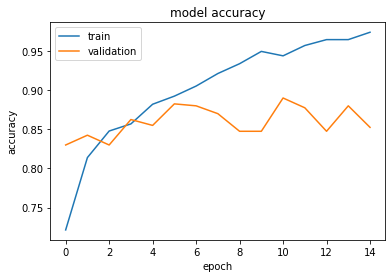

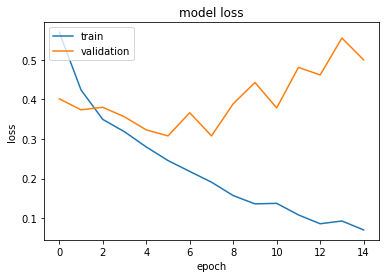

In [0]:
# Plotting the accuracy of "model"
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss of "model"
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


### **model_DO**

In [0]:
model_DO = tf.keras.models.Sequential(
    [
     
     Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(100,100,3)),
     MaxPooling2D(2,2),

     Conv2D(32, (3,3), padding='same', activation='relu'),
     MaxPooling2D(2,2),

     Flatten(),

     Dense(512, activation='relu'),

     Dropout(0.5),

     Dense(1, activation='sigmoid')
     
    ]
)

In [0]:
model_DO.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               10240512  
_________________________________________________________________
dropout (Dropout)            (None, 512)              

In [0]:
model_DO.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['acc']
)

In [0]:
result_DO = model_DO.fit(
    train_generator,
    steps_per_epoch = 160,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 20,
    verbose = 2
)

Epoch 1/15
160/160 - 41s - loss: 0.5901 - acc: 0.7270 - val_loss: 0.4120 - val_acc: 0.8525
Epoch 2/15
160/160 - 37s - loss: 0.4430 - acc: 0.7948 - val_loss: 0.3533 - val_acc: 0.8500
Epoch 3/15
160/160 - 37s - loss: 0.3733 - acc: 0.8375 - val_loss: 0.3604 - val_acc: 0.8375
Epoch 4/15
160/160 - 37s - loss: 0.3500 - acc: 0.8409 - val_loss: 0.3479 - val_acc: 0.8400
Epoch 5/15
160/160 - 37s - loss: 0.3239 - acc: 0.8513 - val_loss: 0.3197 - val_acc: 0.8700
Epoch 6/15
160/160 - 37s - loss: 0.2817 - acc: 0.8776 - val_loss: 0.3266 - val_acc: 0.8575
Epoch 7/15
160/160 - 37s - loss: 0.2558 - acc: 0.8867 - val_loss: 0.3390 - val_acc: 0.8450
Epoch 8/15
160/160 - 37s - loss: 0.2476 - acc: 0.8952 - val_loss: 0.3168 - val_acc: 0.8775
Epoch 9/15
160/160 - 37s - loss: 0.2131 - acc: 0.9121 - val_loss: 0.3055 - val_acc: 0.8925
Epoch 10/15
160/160 - 37s - loss: 0.1927 - acc: 0.9238 - val_loss: 0.3520 - val_acc: 0.8500
Epoch 11/15
160/160 - 37s - loss: 0.1668 - acc: 0.9357 - val_loss: 0.3575 - val_acc: 0.86

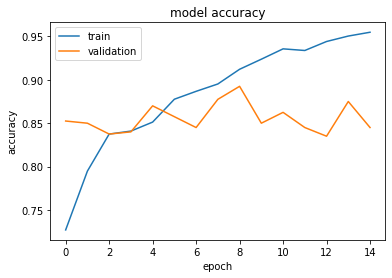

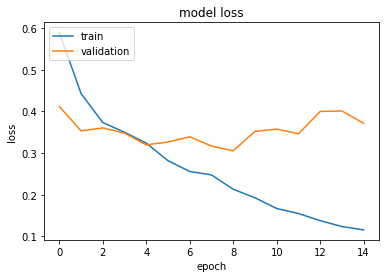

In [0]:
# Accuracy of "model_DO"
plt.plot(result_DO.history['acc'])
plt.plot(result_DO.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss of "model_DO"
plt.plot(result_DO.history['loss'])
plt.plot(result_DO.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


### **model_DO_less**

In [0]:
model_DO_less = tf.keras.models.Sequential(
    [
     
     Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(100,100,3)),
     MaxPooling2D(2,2),

     Conv2D(16, (3,3), padding='same', activation='relu'),
     MaxPooling2D(2,2),

     Flatten(),

     Dense(128, activation='relu'),

     Dropout(0.5),

     Dense(1, activation='sigmoid')
     
    ]
)

In [0]:
model_DO_less.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 100, 8)       224       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 16)        1168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1280128   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [0]:
model_DO_less.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['acc']
)

In [0]:
result_DO_less = model_DO_less.fit(
    train_generator,
    steps_per_epoch = 160,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 20,
    verbose = 2
)

Epoch 1/15
160/160 - 21s - loss: 0.5744 - acc: 0.7204 - val_loss: 0.4433 - val_acc: 0.8000
Epoch 2/15
160/160 - 21s - loss: 0.4461 - acc: 0.8045 - val_loss: 0.4062 - val_acc: 0.8125
Epoch 3/15
160/160 - 21s - loss: 0.4323 - acc: 0.8029 - val_loss: 0.3574 - val_acc: 0.8500
Epoch 4/15
160/160 - 21s - loss: 0.3859 - acc: 0.8302 - val_loss: 0.3298 - val_acc: 0.8650
Epoch 5/15
160/160 - 21s - loss: 0.3700 - acc: 0.8393 - val_loss: 0.3424 - val_acc: 0.8650
Epoch 6/15
160/160 - 21s - loss: 0.3524 - acc: 0.8481 - val_loss: 0.3430 - val_acc: 0.8425
Epoch 7/15
160/160 - 21s - loss: 0.3430 - acc: 0.8481 - val_loss: 0.3255 - val_acc: 0.8575
Epoch 8/15
160/160 - 21s - loss: 0.3247 - acc: 0.8634 - val_loss: 0.2996 - val_acc: 0.8750
Epoch 9/15
160/160 - 21s - loss: 0.3143 - acc: 0.8604 - val_loss: 0.3062 - val_acc: 0.8775
Epoch 10/15
160/160 - 21s - loss: 0.2858 - acc: 0.8801 - val_loss: 0.2981 - val_acc: 0.8825
Epoch 11/15
160/160 - 21s - loss: 0.2784 - acc: 0.8801 - val_loss: 0.2993 - val_acc: 0.86

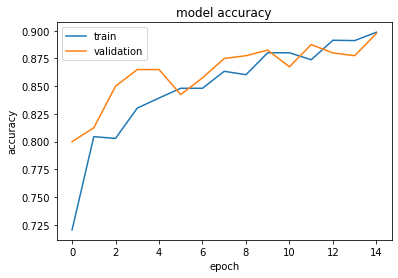

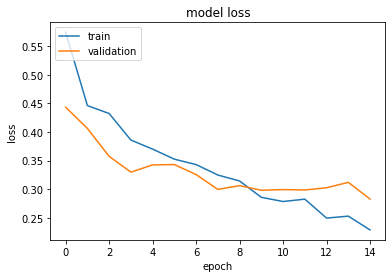

In [0]:
# Accuracy of "model_DO_less"
plt.plot(result_DO_less.history['acc'])
plt.plot(result_DO_less.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss of "model_DO_less"
plt.plot(result_DO_less.history['loss'])
plt.plot(result_DO_less.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


### **model_DO_06_Dense_128**

In [0]:
model_DO_06_Dense_128 = tf.keras.models.Sequential(
    [
     
     Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(100,100,3)),
     MaxPooling2D(2,2),

     Conv2D(16, (3,3), padding='same', activation='relu'),
     MaxPooling2D(2,2),

     Flatten(),

     Dense(128, activation='relu'),

     Dropout(0.6),

     Dense(1, activation='sigmoid')
     
    ]
)

In [0]:
model_DO_06_Dense_128.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 100, 100, 8)       224       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 16)        1168      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [0]:
model_DO_06_Dense_128.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['acc']
)

In [0]:
result_DO_06_Dense_128 = model_DO_06_Dense_128.fit(
    train_generator,
    steps_per_epoch = 160,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 20,
    verbose = 2
)

Epoch 1/15
160/160 - 21s - loss: 0.6279 - acc: 0.6727 - val_loss: 0.4930 - val_acc: 0.7975
Epoch 2/15
160/160 - 25s - loss: 0.5039 - acc: 0.7719 - val_loss: 0.4717 - val_acc: 0.8175
Epoch 3/15
160/160 - 21s - loss: 0.4797 - acc: 0.7848 - val_loss: 0.3880 - val_acc: 0.8425
Epoch 4/15
160/160 - 21s - loss: 0.4194 - acc: 0.8227 - val_loss: 0.3676 - val_acc: 0.8425
Epoch 5/15
160/160 - 21s - loss: 0.4058 - acc: 0.8190 - val_loss: 0.3592 - val_acc: 0.8475
Epoch 6/15
160/160 - 21s - loss: 0.3907 - acc: 0.8293 - val_loss: 0.3361 - val_acc: 0.8575
Epoch 7/15
160/160 - 21s - loss: 0.3543 - acc: 0.8412 - val_loss: 0.3397 - val_acc: 0.8575
Epoch 8/15
160/160 - 21s - loss: 0.3391 - acc: 0.8522 - val_loss: 0.3661 - val_acc: 0.8350
Epoch 9/15
160/160 - 21s - loss: 0.3286 - acc: 0.8557 - val_loss: 0.3144 - val_acc: 0.8775
Epoch 10/15
160/160 - 21s - loss: 0.3081 - acc: 0.8717 - val_loss: 0.3132 - val_acc: 0.8575
Epoch 11/15
160/160 - 21s - loss: 0.2998 - acc: 0.8635 - val_loss: 0.2960 - val_acc: 0.87

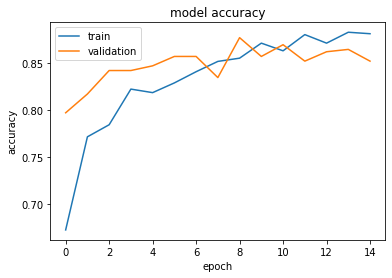

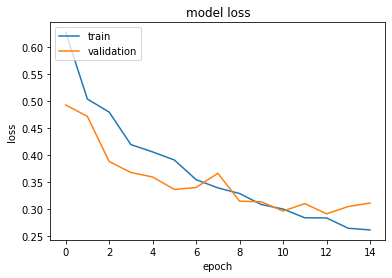

In [0]:
# Accuracy of "model_DO_06_Dense_128"
plt.plot(result_DO_06_Dense_128.history['acc'])
plt.plot(result_DO_06_Dense_128.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.xlabel('epoch')

# Loss of "model_DO_06_Dense_128"
plt.plot(result_DO_06_Dense_128.history['loss'])
plt.plot(result_DO_06_Dense_128.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


### **model_DO_04_Dense_256**

vgg without dropout

In [0]:
model_DO_04_Dense_256 = tf.keras.models.Sequential(
    [
     
     Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(100,100,3)),
     MaxPooling2D(2,2),

     Conv2D(16, (3,3), padding='same', activation='relu'),
     MaxPooling2D(2,2),

     layers.Flatten(),

     Dense(256, activation='relu'),

     Dropout(0.4),

     Dense(1, activation='sigmoid')
     
    ]
)

In [0]:
model_DO_04_Dense_256.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 8)       224       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 16)        1168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2560256   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

In [0]:
model_DO_04_Dense_256.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['acc']
)

In [0]:
result_DO_04_Dense_256 = model_DO_04_Dense_256.fit(
    train_generator,
    steps_per_epoch = 160,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 20,
    verbose = 2
)

Epoch 1/15
160/160 - 22s - loss: 0.5819 - acc: 0.7063 - val_loss: 0.4691 - val_acc: 0.7650
Epoch 2/15
160/160 - 22s - loss: 0.4553 - acc: 0.7951 - val_loss: 0.3642 - val_acc: 0.8500
Epoch 3/15
160/160 - 22s - loss: 0.4048 - acc: 0.8199 - val_loss: 0.3622 - val_acc: 0.8325
Epoch 4/15
160/160 - 23s - loss: 0.3556 - acc: 0.8459 - val_loss: 0.3088 - val_acc: 0.8825
Epoch 5/15
160/160 - 22s - loss: 0.3353 - acc: 0.8478 - val_loss: 0.3473 - val_acc: 0.8550
Epoch 6/15
160/160 - 22s - loss: 0.3113 - acc: 0.8679 - val_loss: 0.3528 - val_acc: 0.8675
Epoch 7/15
160/160 - 22s - loss: 0.2841 - acc: 0.8707 - val_loss: 0.3120 - val_acc: 0.8725
Epoch 8/15
160/160 - 22s - loss: 0.2725 - acc: 0.8820 - val_loss: 0.2880 - val_acc: 0.8825
Epoch 9/15
160/160 - 22s - loss: 0.2327 - acc: 0.8958 - val_loss: 0.3044 - val_acc: 0.8600
Epoch 10/15
160/160 - 22s - loss: 0.2189 - acc: 0.9040 - val_loss: 0.3101 - val_acc: 0.8775
Epoch 11/15
160/160 - 22s - loss: 0.2087 - acc: 0.9125 - val_loss: 0.2648 - val_acc: 0.89

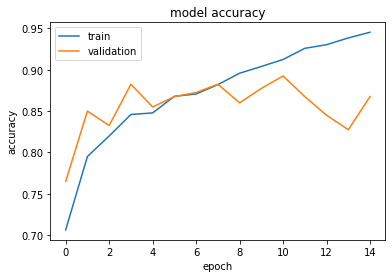

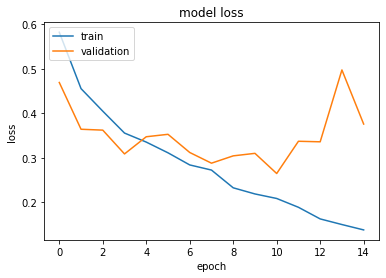

In [0]:
# Accuracy of "model_DO_04_Dense_256"
plt.plot(result_DO_04_Dense_256.history['acc'])
plt.plot(result_DO_04_Dense_256.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss of "model_DO_04_Dense_256"
plt.plot(result_DO_04_Dense_256.history['loss'])
plt.plot(result_DO_04_Dense_256.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **model_vgg**

#### **vgg without dropout**

In [0]:
vgg = VGG16(
    include_top=False, 
    weights='imagenet', 
    input_shape=(100, 100, 3)
    )
# vgg.trainable = False

for layer in vgg.layers:
  layer.trainable = False

In [8]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [9]:
last_layer = vgg.get_layer('block4_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 512)


In [0]:
x = Flatten()(last_output)

x = Dense(256, activation='relu')(x)
#x = Dense(256, activation='relu')(x)

x = Dense(1, activation='sigmoid')(x)

model_vgg = Model(vgg.input, outputs=x)


In [11]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [0]:
model_vgg.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['acc']
)

In [13]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [14]:
result_model_vgg = model_vgg.fit(
    train_generator,
    steps_per_epoch = 160,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 20,
    verbose = 2
)

Epoch 1/15
160/160 - 11s - loss: 1.1457 - acc: 0.7434 - val_loss: 0.3586 - val_acc: 0.8675
Epoch 2/15
160/160 - 11s - loss: 0.3316 - acc: 0.8607 - val_loss: 0.3004 - val_acc: 0.8650
Epoch 3/15
160/160 - 11s - loss: 0.2462 - acc: 0.9002 - val_loss: 0.3886 - val_acc: 0.8200
Epoch 4/15
160/160 - 11s - loss: 0.1683 - acc: 0.9363 - val_loss: 0.2653 - val_acc: 0.8725
Epoch 5/15
160/160 - 11s - loss: 0.1263 - acc: 0.9523 - val_loss: 0.2446 - val_acc: 0.8950
Epoch 6/15
160/160 - 11s - loss: 0.0875 - acc: 0.9736 - val_loss: 0.2334 - val_acc: 0.8975
Epoch 7/15
160/160 - 11s - loss: 0.0698 - acc: 0.9777 - val_loss: 0.1860 - val_acc: 0.9300
Epoch 8/15
160/160 - 11s - loss: 0.0479 - acc: 0.9893 - val_loss: 0.2045 - val_acc: 0.9200
Epoch 9/15
160/160 - 11s - loss: 0.0497 - acc: 0.9849 - val_loss: 0.2119 - val_acc: 0.9275
Epoch 10/15
160/160 - 11s - loss: 0.0271 - acc: 0.9944 - val_loss: 0.2495 - val_acc: 0.8975
Epoch 11/15
160/160 - 11s - loss: 0.0220 - acc: 0.9965 - val_loss: 0.2213 - val_acc: 0.93

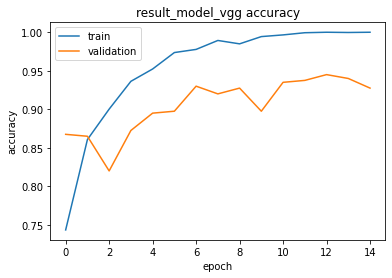

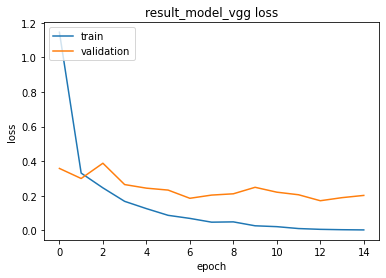

In [15]:
# Accuracy of "result_model_vgg"
plt.plot(result_model_vgg.history['acc'])
plt.plot(result_model_vgg.history['val_acc'])
plt.title('result_model_vgg accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss of "result_model_vgg"
plt.plot(result_model_vgg.history['loss'])
plt.plot(result_model_vgg.history['val_loss'])
plt.title('result_model_vgg loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### **vgg with dropout**

In [0]:
vgg_do = VGG16(
    include_top=False, 
    weights='imagenet', 
    input_shape=(100, 100, 3)
    )
# vgg.trainable = False

for layer in vgg_do.layers:
  layer.trainable = False

In [36]:
vgg_do.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [37]:
last_layer = vgg_do.get_layer('block4_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 512)


In [0]:
x = Flatten()(last_output)

x = Dense(256, activation='relu')(x)
#x = Dense(256, activation='relu')(x)

x = Dropout(0.3)(x)

x = Dense(1, activation='sigmoid')(x)

model_vgg_do = Model(vgg_do.input, outputs=x)

In [39]:
model_vgg_do.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [0]:
model_vgg_do.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['acc']
)

In [41]:
result_model_vgg_do = model_vgg_do.fit(
    train_generator,
    steps_per_epoch = 160,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 20,
    verbose = 2
)

Epoch 1/15
160/160 - 11s - loss: 1.3123 - acc: 0.7132 - val_loss: 0.3572 - val_acc: 0.8425
Epoch 2/15
160/160 - 11s - loss: 0.4005 - acc: 0.8186 - val_loss: 0.3693 - val_acc: 0.8225
Epoch 3/15
160/160 - 11s - loss: 0.3236 - acc: 0.8538 - val_loss: 0.3228 - val_acc: 0.8425
Epoch 4/15
160/160 - 11s - loss: 0.2847 - acc: 0.8770 - val_loss: 0.3148 - val_acc: 0.8575
Epoch 5/15
160/160 - 11s - loss: 0.2678 - acc: 0.8861 - val_loss: 0.2596 - val_acc: 0.8850
Epoch 6/15
160/160 - 11s - loss: 0.2190 - acc: 0.9068 - val_loss: 0.2742 - val_acc: 0.9000
Epoch 7/15
160/160 - 11s - loss: 0.2032 - acc: 0.9190 - val_loss: 0.2439 - val_acc: 0.8950
Epoch 8/15
160/160 - 11s - loss: 0.1639 - acc: 0.9278 - val_loss: 0.2562 - val_acc: 0.9000
Epoch 9/15
160/160 - 11s - loss: 0.1592 - acc: 0.9338 - val_loss: 0.2044 - val_acc: 0.9250
Epoch 10/15
160/160 - 11s - loss: 0.1905 - acc: 0.9175 - val_loss: 0.3667 - val_acc: 0.8700
Epoch 11/15
160/160 - 11s - loss: 0.1715 - acc: 0.9256 - val_loss: 0.2220 - val_acc: 0.91

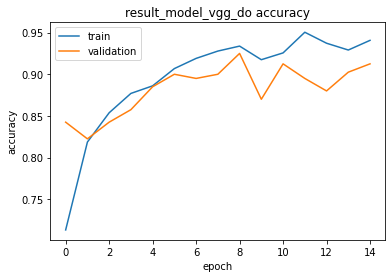

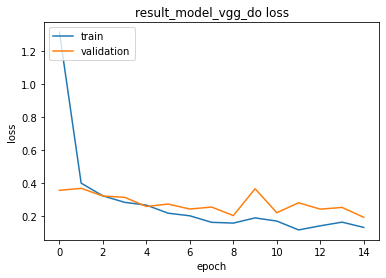

In [42]:
# Accuracy of "result_model_vgg_do"
plt.plot(result_model_vgg_do.history['acc'])
plt.plot(result_model_vgg_do.history['val_acc'])
plt.title('result_model_vgg_do accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss of "result_model_vgg_do"
plt.plot(result_model_vgg_do.history['loss'])
plt.plot(result_model_vgg_do.history['val_loss'])
plt.title('result_model_vgg_do loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
vgg_do_block5 = VGG16(
    include_top=False, 
    weights='imagenet', 
    input_shape=(100, 100, 3)
    )
# vgg.trainable = False

for layer in vgg_do_block5.layers:
  layer.trainable = False

In [56]:
vgg_do_block5.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [57]:
last_layer = vgg_do_block5.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 3, 3, 512)


In [0]:
x = Flatten()(last_output)

x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(1, activation='sigmoid')(x)

model_vgg_do_block5 = Model(vgg_do_block5.input, outputs=x)

In [59]:
model_vgg_do_block5.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [0]:
model_vgg_do_block5.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['acc']
)

In [61]:
result_model_vgg_do_block5 = model_vgg_do_block5.fit(
    train_generator,
    steps_per_epoch = 160,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 20,
    verbose = 2
)

Epoch 1/15
160/160 - 13s - loss: 0.6822 - acc: 0.6178 - val_loss: 0.5503 - val_acc: 0.7425
Epoch 2/15
160/160 - 12s - loss: 0.5099 - acc: 0.7578 - val_loss: 0.4347 - val_acc: 0.8200
Epoch 3/15
160/160 - 12s - loss: 0.4962 - acc: 0.7612 - val_loss: 0.4519 - val_acc: 0.7950
Epoch 4/15
160/160 - 12s - loss: 0.4213 - acc: 0.8070 - val_loss: 0.4105 - val_acc: 0.8025
Epoch 5/15
160/160 - 12s - loss: 0.4084 - acc: 0.8152 - val_loss: 0.4628 - val_acc: 0.7875
Epoch 6/15
160/160 - 12s - loss: 0.3868 - acc: 0.8290 - val_loss: 0.3959 - val_acc: 0.8175
Epoch 7/15
160/160 - 12s - loss: 0.3827 - acc: 0.8362 - val_loss: 0.4051 - val_acc: 0.8150
Epoch 8/15
160/160 - 12s - loss: 0.3410 - acc: 0.8519 - val_loss: 0.3305 - val_acc: 0.8550
Epoch 9/15
160/160 - 12s - loss: 0.3319 - acc: 0.8510 - val_loss: 0.3743 - val_acc: 0.8575
Epoch 10/15
160/160 - 12s - loss: 0.3514 - acc: 0.8359 - val_loss: 0.3731 - val_acc: 0.8300
Epoch 11/15
160/160 - 12s - loss: 0.3181 - acc: 0.8635 - val_loss: 0.4014 - val_acc: 0.82

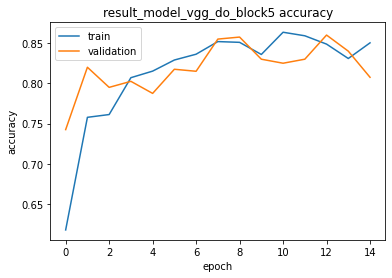

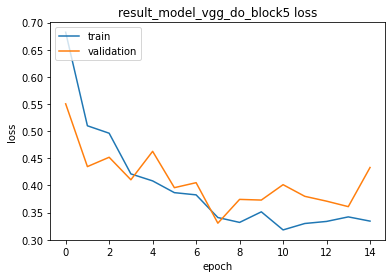

In [62]:
# Accuracy of "result_model_vgg_do_block5"
plt.plot(result_model_vgg_do_block5.history['acc'])
plt.plot(result_model_vgg_do_block5.history['val_acc'])
plt.title('result_model_vgg_do_block5 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss of "result_model_vgg_do_block5"
plt.plot(result_model_vgg_do_block5.history['loss'])
plt.plot(result_model_vgg_do_block5.history['val_loss'])
plt.title('result_model_vgg_do_block5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **model_resnet**

### **model_inception**

# **Evaluation of the models**

### **model**

In [0]:
resEv_model = model.evaluate_generator(test_generator, 20)
print('test loss, test acc:', resEv_model)

test loss, test acc: [0.41369178891181946, 0.8877284526824951]


### **model_DO**

In [0]:
resEv_model_DO = model_DO.evaluate_generator(test_generator, 20)
print('test loss, test acc:', resEv_model_DO)

### **model_DO_04_Dense_256**

In [0]:
resEv_model_DO_04_Dense_256 = model_DO_04_Dense_256.evaluate_generator(test_generator, 20)
print('test loss, test acc:', resEv_model_DO_04_Dense_256)

### **model_DO_06_Dense_128**

In [0]:
resEv_model_DO_06_Dense_128 = model_DO_06_Dense_128.evaluate_generator(test_generator, 20)
print('test loss, test acc:', resEv_model_DO_06_Dense_128)

### **model_DO_less**

In [0]:
resEv_model_DO_less = model_DO_less.evaluate_generator(test_generator, 20)
print('test loss, test acc:', resEv_model_DO_less)

### **model_vgg**

In [20]:
resEv_model_vgg = model_vgg.evaluate_generator(test_generator, 20)
print('test loss, test acc:', resEv_model_vgg)

Instructions for updating:
Please use Model.evaluate, which supports generators.
test loss, test acc: [0.16915468871593475, 0.9449999928474426]


In [63]:
resEv_model_vgg_do_block5 = model_vgg_do_block5.evaluate_generator(test_generator, 20)
print('test loss, test acc:', resEv_model_vgg_do_block5)

test loss, test acc: [0.4503497779369354, 0.7850000262260437]


# **Predict***

In [33]:
# Predicting from some images from the test set

img_width, img_height = 100, 100
img = image.load_img(
        workspace_test + '/benign/'+random.choice(os.listdir(workspace_test + '/benign/')), 
    target_size = (img_width, img_height)
    )
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

model_vgg.predict(img)

array([[1.]], dtype=float32)

In [0]:
# Predicting from some images from the test set

img_width, img_height = 100, 100
img = image.load_img(
        workspace_test + '/benign/'+random.choice(os.listdir(workspace_test + '/benign/')), 
    target_size = (img_width, img_height)
    )
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

model_DO_less.predict(img)

# **Saving models**

In [0]:
model.save(workspace_models + '/Conv16_Max_Conv32_Max_Dense512')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /gdrive/My Drive/Breast_Cancer_Detection/images_resized_2/Saved_Models/Conv16_Max_Conv32_Max_Dense512/assets


In [0]:
model_DO.save(workspace_models + '/Conv16_Max_Conv32_Max_Dense512_DO5')

INFO:tensorflow:Assets written to: /gdrive/My Drive/Breast_Cancer_Detection/images_resized_2/workspace/Saved_Models/Conv16_Max_Conv32_Max_Dense512_DO5/assets


In [0]:
model_DO_less.save(workspace_models + '/Conv8_Max_Conv16_Max_Dense128_DO5')

INFO:tensorflow:Assets written to: /gdrive/My Drive/Breast_Cancer_Detection/images_resized_2/workspace/Saved_Models/Conv8_Max_Conv16_Max_Dense128_DO5/assets


In [0]:
model_DO_04_Dense_256.save(workspace_models + '/Conv8_Max_Conv16_Max_Dense256_DO4')

INFO:tensorflow:Assets written to: /gdrive/My Drive/Breast_Cancer_Detection/images_resized_2/workspace/Saved_Models/Conv8_Max_Conv16_Max_Dense256_DO4/assets


In [0]:
model_DO_06_Dense_128.save(workspace_models + '/Conv8_Max_Conv16_Max_Dense128_DO6')

INFO:tensorflow:Assets written to: /gdrive/My Drive/Breast_Cancer_Detection/images_resized_2/workspace/Saved_Models/Conv8_Max_Conv16_Max_Dense128_DO6/assets


In [34]:
model_vgg.save(workspace_models + '/model_vgg')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /gdrive/My Drive/Breast_Cancer_Detection/images_resized_2/Saved_Models/model_vgg/assets
